---------
# Real Estate Industry Project Summary Notebook


**Group 6 Members:**

Jiayi Zhao,      1067884

Xueke Zheng, 1135290

Yuchen Cao,   1174014

Yuwen Hu,      1173984

Yilong Wang,  1174206

-------
### Project Introduction

Improving living standards has boosted people's requirements for a living environment. For many people, selecting an cost-effective property has become a complicated problem. Companies and individuals who want to invest in real estate may also hesitate because of uncertainty about the direction of the properties' prices and the return on Investment (ROI). 

The summary notebook demonstrates our findings on the trend and influential features of the property rental price for suburbs.

The Summary Notebook only demonstrate overall approach. Detialed code is in the specific notebook, the hyperlinks is provided.


In [2]:
# import all packages needed
import numpy as np
import pandas as pd
import json
import seaborn as sns
import geopandas as gpd
from scipy import stats
import folium
import matplotlib.pyplot as plt

/opt/anaconda3/envs/ads/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


-----------
#### **Table of contents**
1. Download Datasets
2. Web Scrape
3. Properties' Proximity to CBD, School and Train Station.
    
    3.1 Proximity to CBD
    
    3.2 Proximity to School

    3.3 Proximity to Train Station

4. Preprocess and Feature Engineering

    4.1 Preprocess Property Dataset

    4.2 Find Suburb Population

    4.3 Find Suburb Income

    4.5 Find Suburb Offence Count

    4.6 Generate Curated Property Dataset

    4.7 Generate Curated Suburb Dataset

  
5. Model for Property Feature Importance

    5.1 GLM Model (Property)

    5.2 Random Forest Regression (Property)

6.  Model for Suburb Future Rental Cost Estimation
        
    6.1 OLM Model (Suburb)

    6.3 Prediction

    

7. Discussion

8. Suggestion

9. Interactive Map for Suburb Future Estimation
--------

---------
## 1. Download Dataset
Download relevant datasets using URLs.

##### From the Australian Bureau of Statistics (ABS), download the following datasets.
1. Population estimates and components by SA2, 2020 to 2022
2. Projected population, components of change and summary statistics - Australia, state/territory, greater capital city and rest of state, 2017 (base) to 2066
3. Table 1 - Total income 2011-12 to 2017-18
4. Table 1 - Total income 2014-15 to 2018-19
5. Statistical Areas Level 2 - 2021 - Shapefile
6. Statistical Area Level 2 (SA2) ASGS Ed 2016 Digital Boundaries in ESRI Shapefile Format

##### From Crime Statistics Agency, download the following dataset.
1. Data Tables LGA Recorded Offences Year Ending June 2022

##### From DATA VIC, download the following dataset.
1. School Locations 2021

##### From Australia Government Official Website, download the following dataset.
1. VIC Localities SHP GDA20(ZIP)

##### From Matthew Proctor, download the following dataset.
1. Australian Postcodes

##### Following datasets are already in the GitHub repository.
1. Train Station Locations (../data/raw/train_station.csv)
2. Main Hospital List (../data/raw/MainHospitalList.csv)
These two datasets are pre-downloaded for our client because they are very hard to download automatically. The train station location dataset is applied through email from https://datashare.maps.vic.gov.au/.
The hospital data is retrieved from the Open Map Service(OMS).

##### Running the code cell below will download the dataset automatically.


In [3]:
# The script will download dataset automatically
%run ../scripts/dataset_download.py

Set up dir
Start Downloading .......
australian_postcodes.csv finished
SA2_2021_AUST_SHP_GDA2020.zip finished
Start unzip SA2_2021_AUST_SHP_GDA2020.zip
Unzip SA2_2021_AUST_SHP_GDA2020.zip finished
SA2_2016.zip finished
Start unzip SA2_2016.zip
Unzip SA2_2016.zip finished
vic_localities.zip finished
Start unzip vic_localities.zip
Unzip vic_localities.zip finished
population.xlsx finished
income_SA2.xls finished
population_pred.xls finished
income_SA2_2019.xlsx finished
recorded_offences.xlsx finished
school_location.csv finished


#####  Running the code cell below will retrieve useful data from the XLSX file and convert it to CSV
* Retrieve Victoria SA2 income (2012-2018) from <code>income_SA2.xls</code> and stored in [income_SA2_vic.csv](../data/raw/external_data/income_SA2_vic.csv)

* Retrieve Victoria population projection for Greater Melbourne, Rest of Vic and Vic from population_pred.xls stored in the following CSV files.

  [population_pred_greater_melbourne.csv](../data/raw/external_data/population_pred_greater_melbourne.csv)

  [population_pred_rest_vic.csv](../data/raw/external_data/population_pred_rest_vic.csv)

  [population_pred_vic.csv](../data/raw/external_data/population_pred_vic.csv)

* Retrieve Victoria SA2 population from <code>population.xlsx</code> and stored in [population.csv](../data/raw/external_data/population.csv)

* Retrieve Victoria SA2 income (2019) and merge to <code>income_SA2_vic.csv</code> then stored in [income_SA2_full.csv](../data/raw/external_data/income_SA2_full.csv)


In [1]:
%run ../scripts/convert_xls_to_csv.py

##### Preview of Population and Income distribution

In [ ]:
SA2_2016_shp = gpd.read_file("../data/raw/external_data/SA2_shape_2016/SA2_2016_AUST.shp")
SA2_2016_shp = SA2_2016_shp[SA2_2016_shp['STE_NAME16'] == 'Victoria']
SA2_population = pd.read_csv("../data/raw/external_data/population.csv", index_col=[0])
SA2_population = SA2_population.rename(columns={ 'SA2 code' : 'SA2_MAIN16'})
SA2_population['SA2_MAIN16'] = SA2_population['SA2_MAIN16'].astype(str)
SA2_income = pd.read_csv("../data/raw/external_data/income_SA2_full.csv", index_col=[0])
SA2_income = SA2_income[['SA2', '2018-19.3']].rename(columns={'SA2' : 'SA2_MAIN16', '2018-19.3': 'income'})
SA2_income['SA2_MAIN16'] = SA2_income['SA2_MAIN16'].astype(str)
SA2_income['income'] = SA2_income['income'].replace('np', np.nan)
SA2_income['income'] = SA2_income['income'].astype(float)
geoJSON = SA2_2016_shp[['SA2_MAIN16', 'geometry']].drop_duplicates('SA2_MAIN16').dropna(how='any').to_json()

Population distribution map

In [ ]:
SA2_population_map = folium.Map(location=[-37.5, 145], tiles="Stamen Terrain", zoom_start=9)

# refer to the folium documentations on more information on how to plot aggregated data.
population_ch = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='SA2 Population', # name of plot
    data= SA2_population[['SA2_MAIN16', 'ERP 2021']], # data source
    columns=['SA2_MAIN16', 'ERP 2021'], # the columns required
    key_on= 'feature.properties.SA2_MAIN16' , # this is from the geoJSON's properties
    fill_color='Reds', # color scheme
    nan_fill_color='green',
    legend_name='SA2 Population 2021'
)
population_ch.add_to(SA2_population_map)
SA2_population_map

Income distribution map

In [ ]:
SA2_income_map = folium.Map(location=[-37.5, 145], tiles="Stamen Terrain", zoom_start=9)

# refer to the folium documentations on more information on how to plot aggregated data.
income_ch = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='SA2 Income', # name of plot
    data= SA2_income[['SA2_MAIN16', 'income']], # data source
    columns=['SA2_MAIN16', 'income'], # the columns required
    key_on= 'feature.properties.SA2_MAIN16' , # this is from the geoJSON's properties
    fill_color='Reds', # color scheme
    nan_fill_color='green',
    legend_name='SA2 Median Income 2019'
)
income_ch.add_to(SA2_income_map)
SA2_income_map.save("../plots/SA2_income_distribution_map.html")
SA2_income_map

## 2. Web Scrape
* The on-lease properties information is scraped from the Domain website (link : https://www.domain.com.au/rent/vic)

* The Domain is one of the most popular property websites in Australia. Although similar websites like realestate.com.au are trendy, the rental properties published on these websites are predominantly the same. Use python to scrape the current on-lease properties from the website www.domain.com.au.

**NOTE** : Since many other groups may scrape the exact websites, we only use a single thread to scrape to avoid the collapse of the website server. Therefore, the scrape script will took roughly 5 hours. So we also provided pre-scraped property data for time efficiency. 
The pre-scraped property information is stored in [property_raw.json](../data/raw/property_raw.json), could skip the code cell below.

In [ ]:
# Tooks more than 5 hours to run this cell.
%run ../scripts/scrape.py
%run ../scrupts/scrape2.py

##### Preview of property raw data

In [9]:
property_raw = pd.read_json('../data/raw/property_raw.json')
property_raw = property_raw.transpose()
property_raw = property_raw.reset_index(drop=True)
property_raw.head(5)

,name,cost_text,coordinates,rooms,type
0,1901/368 St Kilda Road Melbourne VIC 3000,$1800 Per Week,"[-37.8318086, 144.9710272]","[3 Beds, 2 Baths, 2 Parking]",Apartment / Unit / Flat
1,1211/200 Spencer Street Melbourne VIC 3000,$480 per week,"[-37.816228, 144.9532465]","[1 Bed, 1 Bath, 1 Parking]",Apartment / Unit / Flat
2,1008/380 Little Lonsdale Street Melbourne VIC ...,$400 pw,"[-37.8121026, 144.9581291]","[1 Bed, 1 Bath]",Apartment / Unit / Flat
3,3/27 Flinders Lane Melbourne VIC 3000,$420 per week,"[-37.8147317, 144.9733655]","[1 Bed, 1 Bath]",Apartment / Unit / Flat
4,611/408 Lonsdale Street Melbourne VIC 3000,$350,"[-37.8125979, 144.9604012]","[1 Bed, 1 Bath]",Apartment / Unit / Flat


**We obtained 15347 properties information from the Domain.**

In [ ]:
# This cell display the distribution of rental properteis
property_raw_sample = property_raw.sample(n = 200, random_state=30034)

property_map = folium.Map(location=[-37, 145], tiles="Stamen Terrain", zoom_start=8)

def plotPropertyDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.coordinates[0], point.coordinates[1]],
                        radius=5,
                        weight=1,#remove outline
                        popup = point.type,
                        fill_color='red').add_to(property_map)

property_raw_sample.apply(plotPropertyDot, axis=1)
property_map

-------
## 3. Properties' Proximity to CBD, School and Train Station

In [18]:
# Load boundaries file of SA2 and Suburbs
SA2_2020_shp = gpd.read_file("../data/raw/external_data/SA2_shape/SA2_2021_AUST_GDA2020.shp")
SA2_2020_shp = SA2_2020_shp[SA2_2020_shp['STE_NAME21'] == 'Victoria']
SA2_2016_shp = gpd.read_file("../data/raw/external_data/SA2_shape_2016/SA2_2016_AUST.shp")
SA2_2016_shp = SA2_2016_shp[SA2_2016_shp['STE_NAME16'] == 'Victoria']
suburb_shp = gpd.read_file("../data/raw/external_data/vic_localities/vic_localities.shp")

**We use Open Route Service(ORS) API to find the properties's proximity to CBD, School and Train Station.**
#### Application programming interface (API)
* What is API?

  An API is a way for two or more computer programs to communicate with each other. It is a software interface that provides a service to other software.

* What is ORS?

  ORS is much more than a website with a route service for cars, pedestrians and bicycles based on Open Standards and Open Geodata. Several Location Based Services (LBS) created from OSM data are available,  for example :

    * Directions Service
    * Matrix Service
    * Geocoding Service
    * Locations Service
    * Isochrones Service

This project predomaintly use the **Matrix Service**
* Matrix Service
  * Obtain one-to-many, many-to-one and many-to-many matrices for time and distance.

  * For our report, we use the distance matrix to request the distance between each property and the three points of CBD, nearest school and nearest station.

**NOTE** :  please use your own ORS key

#### 3.1 Proximity to CBD
The detailed code is in the notebook [distance_to_CBD](./distance_to_CBD.ipynb)
1. Use Flinders Street Station geographic coordinate to represent CBD
2. Use the ORS API to find the route distance between property and CBD
3. Store the data

Please **RUN ALL** code cells in the notebook [distance_to_CBD](./distance_to_CBD.ipynb), to obtain route distance data.

**BUT**, due to the limited calls for a single API key, we also provided a CSV file ([distance_to_CBD.csv](../data/raw/distance_to_CBD.csv)) contains the ORS output for the pre-scraped rental properties.

In [18]:
proximity_CBD = pd.read_csv("../data/raw/distance_to_CBD.csv", index_col=[0])
proximity_CBD.head(2)

,name,CBD_distance
0,1901/368 St Kilda Road Melbourne VIC 3000,1702.19
1,1211/200 Spencer Street Melbourne VIC 3000,2267.13


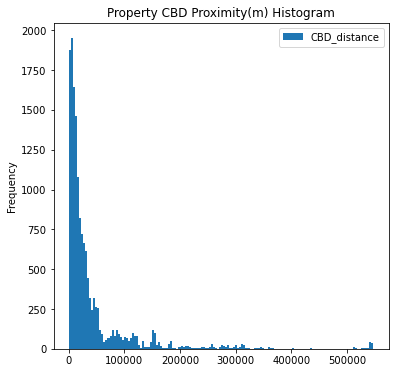

In [19]:
ax_CBD = proximity_CBD.plot.hist(bins=150, 
                                 column='CBD_distance', 
                                 figsize=(6,6), 
                                 title='Property CBD Proximity(m) Histogram',
                                 xlabel = 'Route Distance (m)',
                                 ylabel = 'Frequency')

As demonstrate in the histogram above, the CBD distance are highly right skewed, which indicates that most on-lease properties are around melbourne.

#### 3.2 Proximity to School
The detailed code is in the notebook [distance_to_school](./distance_to_school.ipynb)
1. Find the closest school to every property in the coordinate system
3. Use the ORS API to find the route distance between property and its closest school
4. Store the data

Please **RUN ALL** code cells in the notebook [distance_to_school](./distance_to_school.ipynb) to obtain route distance data.

**BUT**, due to the limited calls for a single API key, we also provided a CSV file ([properties_school_proximity.csv](../data/raw/properties_shcool_proximity.csv)) contains the ORS output for the pre-scraped rental properties.

In [49]:
proximity_school = pd.read_csv("../data/raw/properties_shcool_proximity.csv", index_col=[0])
proximity_school.head()

,name,cost_text,coordinates,rooms,type,coord,closest school,proximity to school
0,1901/368 St Kilda Road Melbourne VIC 3000,$1800 Per Week,"[-37.8318086, 144.9710272]","['3 Beds', '2 Baths', '2 Parking']",Apartment / Unit / Flat,"[144.9710272, -37.8318086]",1374,667.06
1,1211/200 Spencer Street Melbourne VIC 3000,$480 per week,"[-37.816228, 144.9532465]","['1 Bed', '1 Bath', '1 Parking']",Apartment / Unit / Flat,"[144.9532465, -37.816228]",2265,352.49
2,1008/380 Little Lonsdale Street Melbourne VIC ...,$400 pw,"[-37.8121026, 144.9581291]","['1 Bed', '1 Bath']",Apartment / Unit / Flat,"[144.9581291, -37.8121026]",2189,401.73
3,3/27 Flinders Lane Melbourne VIC 3000,$420 per week,"[-37.8147317, 144.9733655]","['1 Bed', '1 Bath']",Apartment / Unit / Flat,"[144.9733655, -37.8147317]",2193,586.61
4,611/408 Lonsdale Street Melbourne VIC 3000,$350,"[-37.8125979, 144.9604012]","['1 Bed', '1 Bath']",Apartment / Unit / Flat,"[144.9604012, -37.8125979]",2265,779.91


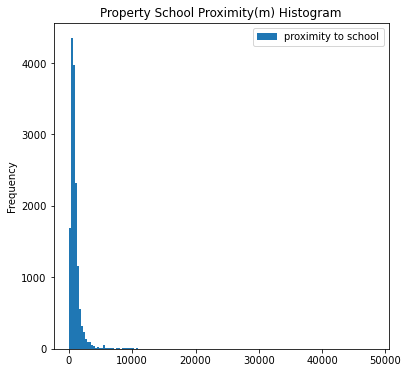

In [53]:
ax_school = proximity_school.plot.hist(bins=150, 
                                      column='proximity to school', 
                                      figsize=(6,6), 
                                      title='Property School Proximity(m) Histogram',
                                      xlabel = 'Route Distance (m)',
                                      ylabel = 'Frequency')

As demonstrate in the histogram above, the school distance are highly right skewed, which indicates that majority on-lease properties have access to school.

#### 3.2 Proximity to Train Station
The detailed code is in the notebook [distance_to_train_station](./distance_to_train_station.ipynb)
1. Find the closest school to every property in the coordinate system
3. Use the ORS API to find the route distance between property and its closest school
4. Store the data

Please **RUN ALL** code cells in the notebook [distance_to_train_station](./distance_to_train_station.ipynb) to obtain route distance data.

**BUT**, due to the limited calls for a single API key, we also provided a CSV file ([properties_train_proximity.csv](../data/raw/properties_train_proximity.csv)) contains the ORS output for the pre-scraped rental properties.

In [51]:
proximity_train= pd.read_csv("../data/raw/properties_train_proximity.csv", index_col=[0])
proximity_train.head()

,name,cost_text,coordinates,rooms,type,closest station,proximity to train station
0,1901/368 St Kilda Road Melbourne VIC 3000,$1800 Per Week,"[-37.8318086, 144.9710272]","['3 Beds', '2 Baths', '2 Parking']",Apartment / Unit / Flat,30,1803.65
1,1211/200 Spencer Street Melbourne VIC 3000,$480 per week,"[-37.816228, 144.9532465]","['1 Bed', '1 Bath', '1 Parking']",Apartment / Unit / Flat,176,371.68
2,1008/380 Little Lonsdale Street Melbourne VIC ...,$400 pw,"[-37.8121026, 144.9581291]","['1 Bed', '1 Bath']",Apartment / Unit / Flat,28,248.50
3,3/27 Flinders Lane Melbourne VIC 3000,$420 per week,"[-37.8147317, 144.9733655]","['1 Bed', '1 Bath']",Apartment / Unit / Flat,140,404.26
4,611/408 Lonsdale Street Melbourne VIC 3000,$350,"[-37.8125979, 144.9604012]","['1 Bed', '1 Bath']",Apartment / Unit / Flat,28,525.08


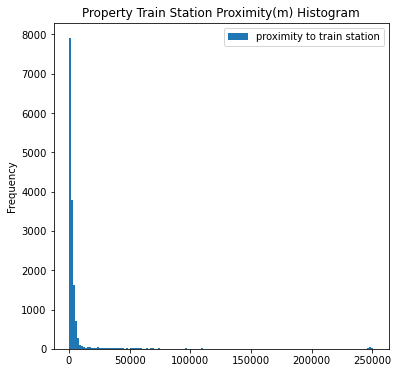

In [54]:
ax_train = proximity_train.plot.hist(bins=150, 
                                      column='proximity to train station', 
                                      figsize=(6,6), 
                                      title='Property Train Station Proximity(m) Histogram',
                                      xlabel = 'Route Distance (m)',
                                      ylabel = 'Frequency')

As demonstrate in the histogram above, the station distance are highly right skewed, which indicates that majority on-lease properties have access to train station.

-------------
## 4. Preprocess and Feature Engineering
4.1 Preprocess Property Dataset

4.2 Find Suburb Population

4.3 Find Suburb Income

4.5 Find Suburb Offence Count

4.6 Generate Curated Property Dataset

4.7 Generate Curated Suburb Dataset

### 4.1 Preprocess Property Dataset
The detailed code is in the notebook [preprocess_property_1](./preprocess_property_1.ipynb)

1. Merge API request data to property data
2. Preprocess property data
    * Split postcode and address
    * Unify cost measurement to weekly cost
    * Split 'rooms' to number of bedrooms, bathrooms and parking
3. Find property's suburb and SA2

Please **RUN ALL** code cells in the notebook [preprocess_property_1](./preprocess_property_1.ipynb), before run following cells.

In [23]:
property_1 = pd.read_csv("../data/raw/properties_preporcessed_1.csv", index_col=[0])
property_1.head(2)
# Ref:
# SA2_MAIN16 ---- 2016 version SA2 code
# SA2_CODE21 ---- 2020 version SA2 code
# LOC_PID ---- Suburb ID 
# LOC_NAME ---- Suburb name

,name,cost_text,rooms,type,cloest station,station_distance,cloest school,school_distance,CBD_distance,postcode,...,text,beds,bath,parking,Longitude,Latitude,SA2_CODE21,LOC_PID,LOC_NAME,SA2_MAIN16
0,1901/368 St Kilda Road Melbourne VIC 3000,$1800 Per Week,"['3 Beds', '2 Baths', '2 Parking']",Apartment / Unit / Flat,30,1803.65,1374,667.06,1702.19,3000,...,Per Week,3,2,2,144.971027,-37.831809,206051512.0,loc9901d119afda,Melbourne,206051132.0
1,1211/200 Spencer Street Melbourne VIC 3000,$480 per week,"['1 Bed', '1 Bath', '1 Parking']",Apartment / Unit / Flat,176,371.68,2265,352.49,2267.13,3000,...,per week,1,1,1,144.953247,-37.816228,206041505.0,loc9901d119afda,Melbourne,206041122.0


Investigate the weekly rent distribution

In [24]:
property_1_plot = property_1[(np.abs(stats.zscore(property_1['cost'])) <2.5)]  # remove some extrem values

* Frequency Histogram

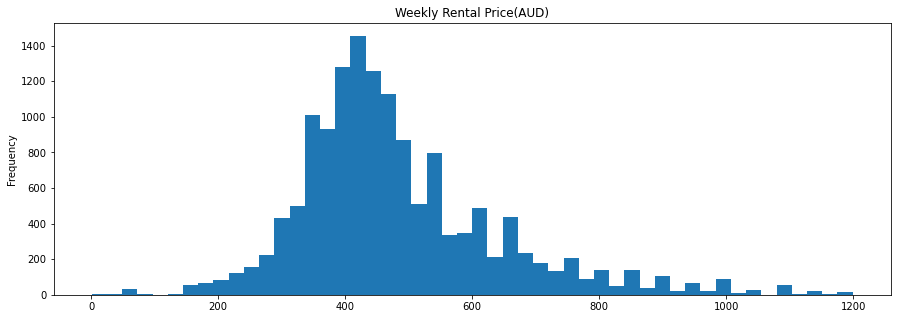

In [25]:
ax_property_cost = property_1_plot['cost'].plot.hist(bins=50, 
                                                      column='cost', 
                                                      figsize=(15,5), 
                                                      title='Weekly Rental Price(AUD)',
                                                      ylabel = 'Frequency')

* Density Curve

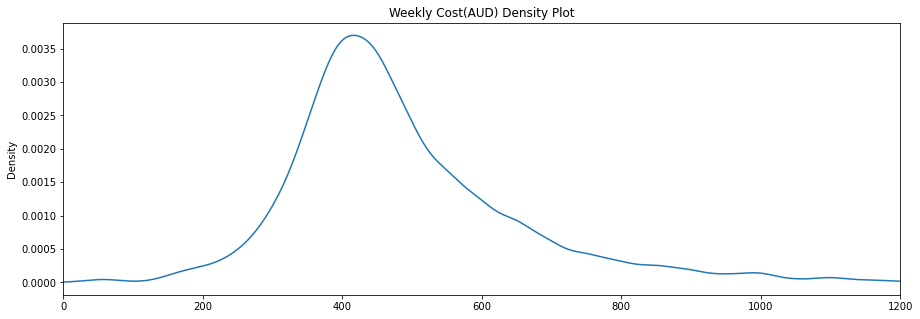

In [26]:
ax_property_cost_density = property_1_plot['cost'].plot.density(figsize=(15,5), 
                                                                xlim=[0, 1200],
                                                                title = 'Weekly Cost(AUD) Density Plot',
                                                                xlabel = 'Weekly Cost($)',
                                                                ylabel = 'Density')

* Normal PDF

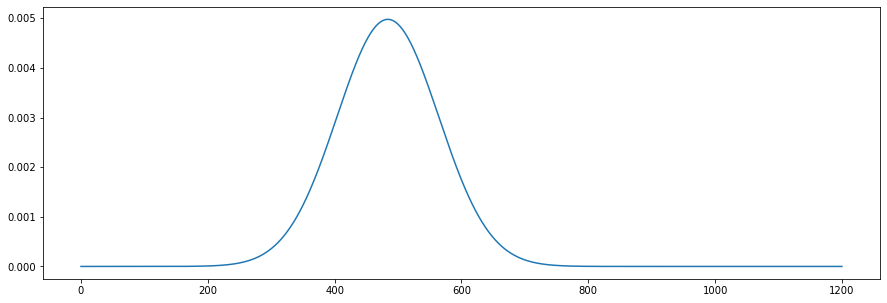

In [86]:
# Plot between -10 and 1200 with .001 steps.
x_axis = np.arange(0, 1200, 0.1)
mean = property_1_plot['cost'].mean()
std = property_1_plot['cost'].std()/2
ax_normal = plt.figure(figsize=(15,5))
plt.plot(x_axis, stats.norm.pdf(x_axis,mean,std))
plt.show()

* From three plots above, we found that the cost may approximately normally distributed.

Investigae the cost correlation with distance to train station, school and CBD.

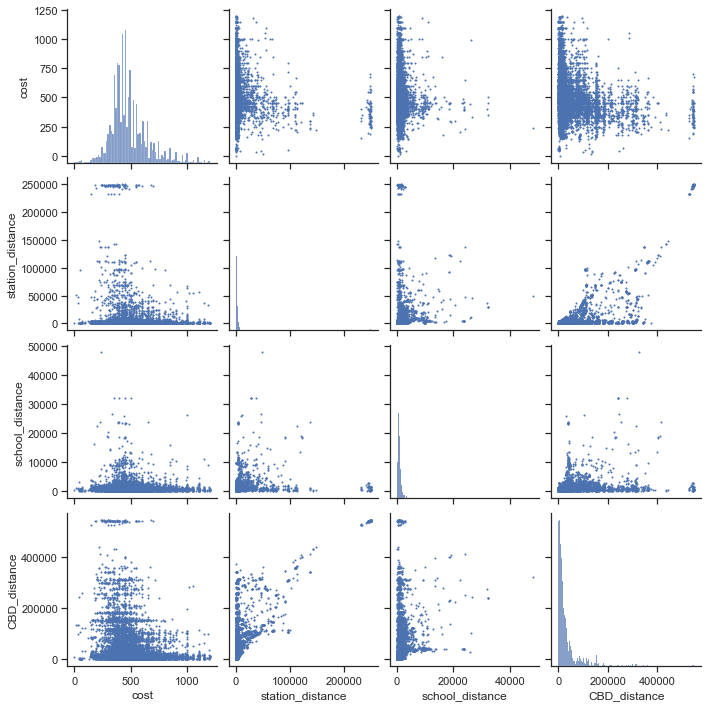

In [28]:
COL= ['cost', 'station_distance',	'school_distance',	'CBD_distance'] # Select features 
sns.set(style="ticks", color_codes=True)
p_plot = sns.pairplot(property_1_plot[COL], plot_kws=dict(s=1, edgecolor="b", linewidth=1)) # scatter plot of total data

##### **MORE** analysis is in notebook [analysis](./analysis.ipynb)

### 4.2 Find Suburb Population
The detailed code is in the notebook [population_for_suburb](./population_for_suburb.ipynb)

1. Find that population positively correlated with the number of the properties in the region.

      ![population property count scatter plot](../plots/population_property_scatter.jpeg)


2. Find the proportion of properties between the intersection of each SA2 and suburb and its SA2.
3. Find the population of every suburb according to the proportion of intersection and the population of SA2.
      
      $\text{Estimated Suburb Population} = \sum_i^n{\frac{\text{number of properties}}{\text{total number of properties in SA2}_i} \times \text{Population of SA2}_i}$

4. Find the density of population for every suburb.

Please **RUN ALL** code cells in the notebook [population_for_suburb](./population_for_suburb.ipynb), before run following cells.

In [29]:
suburb_population = pd.read_csv("../data/raw/population_for_suburb.csv", index_col=[0])
suburb_population.head(2)

,LOC_PID,suburb_population,LOC_NAME,suburb_area,density
0,loc0067a4549ed1,4897.0,Korumburra,59.867302,81.797573
1,loc00a9769647d7,26158.0,Kew,10.520939,2486.279947


For suburb future population projection. The detailed code is in the notebook [populaiton_projection](./population_projections.ipynb)

- If the suburb is in the greater melbourne region, we use the greater melbourne growth rate to estimate future population

- If the suburb is in the rest of victoria region, we use the rest of vic. growth rate to estimate future population

Please **RUN ALL** code cells in the notebook [populaiton_projection](./population_projections.ipynb), before run following cells.

In [31]:
suburb_population_proj = pd.read_csv("../data/raw/population_projection.csv", index_col=[0])
suburb_population_proj.head(2)

,LOC_PID,suburb_population,population_proj_2022,population_proj_2023,population_proj_2024,population_proj_2025
1,loc00a9769647d7,26158.0,26760,27348,27923,28481
2,loc00d1503504f1,41928.0,42892,43836,44757,45652


### 4.3 Find Suburb Income
The detailed code is in the notebook [income](./income.ipynb)

1. Assume the linear growth of Australia income in future

    ![Historical Income Data Line Plot](../plots/income_sample_1.jpeg)

    As the plot demonstrate above, victoria regional income growth in a roughly constant rate, therefore use past average increase rate to predit future income may be a good choice
2. Calculate the average income growth rate for each SA2 from 2011 to 2019
3. Forecast income for each SA2 from 2020 to 2025
4. For data with missing value, the Overall Average annual growth rate of income was used to calculate

    - **Income with missing value**: Because of incomplete data, the Overall Average Annual growth rate of income was used to calculate. Through the annual income boxplot, found that the annual income distribution is skewed distribution, so use the ratio of median every two years to get growth averaging rate.

    - **Assumption**: Assume that the income growth rate of SA2 with missing value is the same as the average income growth rate of the whole state of Victoria
    
5. Merge income data and property data with SA2

6. Find Suburb income

Please **RUN ALL** code cells in the notebook [income](./income.ipynb), before run following cells.

In [10]:
suburb_income = pd.read_csv("../data/raw/income_for_suburb.csv")
suburb_income.head()

,LOC_NAME,2011-12.3,2012-13.3,2013-14.3,2014-15.3,2015-16.3,2016-17.3,2017-18.3,2018-19.3,2019,2020,2021,2022,2023,2024,2025
0,Abbotsford,50034.0,50558.0,51419.0,53987.0,57501.0,58359.0,61476.0,64090.0,66409.949224,68813.876673,71304.822215,73885.935758,76560.481231,79331.840710,82203.518699
1,Aberfeldie,50458.0,52097.0,53037.0,54683.0,56381.0,56597.0,59116.0,61204.0,62920.085721,64684.288398,66497.957172,68362.479013,70279.279779,72249.825306,74275.622534
2,Aintree,38711.0,39709.0,40111.0,38717.0,39657.0,43924.0,48697.0,51869.0,54142.564367,56515.785463,58993.031525,61578.862259,64278.037238,67095.524658,70036.510488
3,Airport West,45090.0,46837.0,48941.0,50094.0,52329.0,53575.0,55912.0,58506.0,60726.452293,63031.176428,65423.370737,67906.354937,70483.574736,73158.606615,75935.162795
4,Albanvale,38444.0,40266.0,40038.0,41211.0,41238.0,41394.0,43026.0,44383.0,45311.439040,46259.299910,47226.988890,48214.920761,49223.518980,50253.215862,51304.452765


### 4.5 Find Suburb Offence Count
The detailed code is in the notebook [preprocess_crime](./preprocess_crime.ipynb)

1. Find each suburb total offence count in past two years.
2. Scale the total count by the population.
    - $\text{scaled offence count} = \frac{\text{total suburb offence count}}{\text{suburb population}}$
    - We Found that the total offence count are hightly correlated with suburb population

    ![offence count pair plot](../plots/suburb_offence_pair.jpeg)

    - But the correlation after the count scaled by the population is very weak

    ![offence count correlation](../plots/suburb_offence_corr.jpeg)
    
Please **RUN ALL** code cells in the notebook [preprocess_crime](./preprocess_crime.ipynb), before run following cells.

In [4]:
suburb_crime = pd.read_csv("../data/raw/crime_completed.csv", index_col=[0])
suburb_crime.head()

,LOC_PID,LOC_NAME,offence_count_scaled
0,locb9872f35df41,Abbotsford,0.280808
1,loc8123ed12ea8d,Aberfeldie,0.141229
2,loc0be4112ae167,Aintree,0.222535
3,locdeefa3afa7c5,Airport West,0.185012
4,locff0c231b0f12,Albanvale,0.132689


### 4.6 Generate Curated Property Dataset
The detailed code is in the notebook [preprocess_property_2](./preprocess_property_2.ipynb)

1. Merge suburb population
2. Merge suburb scaled offence count
3. Merge suburb median income

Please **RUN ALL** code cells in the notebook [preprocess_property_2](./preprocess_property_2.ipynb), before run following cells.

In [6]:
property_curated = pd.read_csv("../data/curated/property_final.csv", index_col=[0])
property_curated.head()

,type,cloest station,station_distance,cloest school,school_distance,CBD_distance,postcode,address,cost,beds,bath,parking,LOC_PID,LOC_NAME,suburb_population,density,offence_count_scaled,2022_income
0,Apartment / Unit / Flat,30,1803.65,1374,667.06,1702.19,3000,1901/368 St Kilda Road Melbourne,1800.0,3,2,2,loc9901d119afda,Melbourne,64537.612413,9902.586904,0.637907,59707.937643
1,Apartment / Unit / Flat,176,371.68,2265,352.49,2267.13,3000,1211/200 Spencer Street Melbourne,480.0,1,1,1,loc9901d119afda,Melbourne,64537.612413,9902.586904,0.637907,59707.937643
2,Apartment / Unit / Flat,28,248.50,2189,401.73,1937.39,3000,1008/380 Little Lonsdale Street Melbourne,400.0,1,1,0,loc9901d119afda,Melbourne,64537.612413,9902.586904,0.637907,59707.937643
3,Apartment / Unit / Flat,140,404.26,2193,586.61,790.13,3000,3/27 Flinders Lane Melbourne,420.0,1,1,0,loc9901d119afda,Melbourne,64537.612413,9902.586904,0.637907,59707.937643
4,Apartment / Unit / Flat,28,525.08,2265,779.91,1657.95,3000,611/408 Lonsdale Street Melbourne,350.0,1,1,0,loc9901d119afda,Melbourne,64537.612413,9902.586904,0.637907,59707.937643


### 4.7 Generate Curated Suburb Dataset
The detailed code is in the notebook [preprocess_suburb](./preprocess_suburb.ipynb)

1. Find Average Rental Price of Suburbs
2. Merge Population, Income
3. Merge Number of Schools, Hospitals and Train Stations
4. Generate Future Suburb Data.

Please **RUN ALL** code cells in the notebook [preprocess_suburb](./preprocess_suburb.ipynb), before run following cells.

In [12]:
# Current Suburb Data
suburb_curated = pd.read_csv("../data/curated/suburb_final.csv", index_col=[0])
suburb_curated.head(2)

,LOC_PID,LOC_NAME,rental_price,suburb_population,population_density,offence_count_scaled,income,num_stations,num_schools,num_hospitals
0,loc0067a4549ed1,Korumburra,278.333333,4897.0,81.797573,0.165407,47097.371969,0.0,3.0,0.0
1,loc00a9769647d7,Kew,621.281250,26158.0,2486.279947,0.107577,71097.931084,0.0,11.0,6.0


--------
## 5. Model for Property Feature Importance

5.1 GLM Model (Property)

5.2 Random Forest Regression (Property)

### 5.1 GLM Model (Property)
The detailed code is in the R-markdown [preprocess_suburb](./preprocess_suburb.ipynb)

### 5.2 Random Forest Regression (Property)

##### What is Random Forest Regression
The Random Forest Regression is an ensemble learning model that operates by constructing a multitude of decision trees at training time. For estimating, the mean or average prediction of the individual trees is returned. Random decision forests correct for decision trees' habit of overfitting to their training set.

![random_forest_demo](../plots/RFR_demo.png)

<br>

The detailed code is in the notebook [random_forest](./random_forest.ipynb)

1. Feature Selection and Preprocessing.
2. Random Forest Modeling.
3. Model evaluation.
4. Importance of features

Please **RUN ALL** code cells in the notebook [random_forest](./random_forest.ipynb), before run following cells.

##### The Random Forest Regression Model (RFR) Output
The RFR provides the importance of features

  ![RF_feature_importance](../plots/RF_feature_importance.jpeg)

  red : internal features

  blue : external features

------------
## 6.  Model for Suburb Future Rental Cost Estimation
